## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 9 октября 2019

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 23 октября (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 30 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [94]:
import numpy as np
import pandas as pd

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [95]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [96]:
data.shape

(48895, 16)

In [97]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [98]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

In [99]:
data.name.fillna('', inplace = True)
data.host_name.fillna('', inplace = True) #пустая строка
data.last_review.fillna(data.last_review.value_counts().index[0], inplace = True) #самое популярнное знач
data.reviews_per_month.fillna(data.reviews_per_month.mean(), inplace = True) #среднее

In [100]:
s = ['room_type', 'host_name', 'neighbourhood_group', 'neighbourhood']
#эти признаки будем считать категориальными

In [101]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for ch in s:
    data[ch+'_labels'] = labelencoder.fit_transform(data[ch])
    
#label encoding категориальных признаков

In [102]:
import time
data['last_review_sec'] = data['last_review'].apply(lambda s: time.mktime(time.strptime(s, '%Y-%m-%d')))

#переведем last_review из строковой переменной в вещественную

Разобъем данные на обучение и контроль.

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

Сделаем предподсчет признаков, необходимых для дальнейшего вычисления метрик и добавим их в dataframe

In [104]:
def counts(x, x_train):
    cnt = [np.sum(a == x_train) for a in x]
    return np.array(cnt)

In [105]:
for ch in s:
    data[ch+'_cnt'] = counts(data[ch+'_labels'].values, X_train[ch+'_labels'].values)
#сколько раз значение категориального признака встретилось в обучающей выборке

In [106]:
for ch in s:
    data[ch+'_p'] = data[ch+'_cnt'].apply(lambda s: s * (s - 1) / X_train.shape[0] / (X_train.shape[0] -1))
#вероятность того, что 2 случайно выбранных признака примут текущее значение

In [107]:
for ch in s:
    p2 = np.array(data[ch+'_p'])
    a = data.groupby(ch).mean()[ch+'_p'].values
    b = [np.sum(a[a <= j]) for j in p2]
    data[ch+'_p_sum'] = b

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
Сигнатуру методов при желании можно менять.

In [150]:
from typing import Union, Callable, Iterable, Optional
from sklearn.neighbors import NearestNeighbors
import scipy

class KNNRegressor:
    def __init__(self, n_neighbors: int, metric: Union[str, Callable], mode: str = 'uniform'):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
        """
        self.__nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
        self.__mode = mode
        self.__n_neighbors = n_neighbors

    def fit(self, X, y) -> None:
        """
            X: data
            y: labels
        """
        if type(X) != scipy.sparse.csr.csr_matrix:
            data = np.array(X.copy())
        else:
            data = X
        self.__nn.fit(data, y)
        self.__y = np.copy(y).reshape(-1,)
        # Ваш код здесь
        pass

    def predict(self, X, n_neighbors: Optional[int] = None) -> np.array:
        """
            X: data
            n_neighbors: number of neighbors
        """
        self.__eps = 1e-5
        if type(X) != scipy.sparse.csr.csr_matrix:
            Z = np.array(X.copy())
        else:
            Z = X
        dist, idx = self.__nn.kneighbors(Z, n_neighbors = n_neighbors)
        if self.__mode == 'distance':
            w = 1 / (dist + self.__eps)
            coef = w.sum(axis = 1)
            answers = self.__y[idx] * w 
        else:
            answers = self.__y[idx]
            coef = n_neighbors
        answers = answers.sum(axis = 1) / coef
        return answers
    

In [152]:
#подсчет RMSE для нескольких значений числа ближайших соседей из K_list для взвешенного и невзвешенного методов

def knn_score(X_tr, y_tr, X_ts, y_ts, k_list, metric, mode = "dist_uniform"):
    if type(X_tr) != scipy.sparse.csr.csr_matrix:
        X_train = np.array(X_tr.copy())
    else:
        X_train = X_tr
    if type(X_ts) != scipy.sparse.csr.csr_matrix:
        X_test = np.array(X_ts.copy())
    else:
        X_test = X_ts           
    y_train = np.copy(y_tr).reshape(-1,)
    y_test = np.copy(y_ts).reshape(-1,)

    m = NearestNeighbors(n_neighbors=max(k_list), metric=metric)
    sc_u = []
    sc_d = []
    m.fit(X_train, y_train)
    dist, idx = m.kneighbors(X_test, n_neighbors = max(k_list))
    for k in k_list:
        d = dist[:, :k]
        i = idx[:, :k]
        #distance
        w = 1 / (d + 1e-5)
        coef = w.sum(axis = 1)
        answers = y_train[i] * w 
        answers = answers.sum(axis = 1) / coef
        sc_d.append(np.sqrt(np.sum((answers - np.array(y_test).reshape(-1,)) ** 2) / len(answers)))  
        
        #uniform
        answers = y_train[i]
        coef = k
        answers = answers.sum(axis = 1) / coef
        sc_u.append(np.sqrt(np.sum((answers - np.array(y_test).reshape(-1,)) ** 2) / len(answers)))   
        
    return sc_d, sc_u

## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на [третьем семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2019/blob/master/lecture-notes/Sem03_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [1]:
import numpy as np

In [2]:
x = np.arange(10)

In [3]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
x[:x.shape[0]//3]

array([0, 1, 2])

In [5]:
x[2*x.shape[0]//3:]

array([6, 7, 8, 9])

In [153]:
def overlap(x, z):
    x = x[:x.shape[0]//3]
    z = z[:z.shape[0]//3]
    return  np.sum(x != z)

def flattened_overlap(x, z):
    x1 = x[:x.shape[0]//3]
    z1 = z[:z.shape[0]//3]
    x2 = x[2*x.shape[0]//3:]
    z2 = z[2*z.shape[0]//3:]
    
    eq = np.array([x1 == z1])
    n_eq = np.array([x1 != z1])
    
    return np.sum(n_eq + eq * x2) 

def log_overlap(x, z):
    x1 = x[:x.shape[0]//3]
    z1 = z[:z.shape[0]//3]
    x2 = x[x.shape[0]//3:2*x.shape[0]//3]
    z2 = z[z.shape[0]//3:2*z.shape[0]//3]
    n_eq = np.array([x1 != z1])
    x_log = np.log(x2 + 1)
    z_log = np.log(z2 + 1)
    return np.sum(n_eq * x_log * z_log)


#x, z состоят из 3 частей: значение признака, сколько раз это значение признака встретилось в обучающей выборке,
# сумма вероятностей того, что 2 случайно выбранных признака примут одинаковое значение, которые меньше вер-ти для текущего значения

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

<b>Ответ:</b> 

1. overlap distance 235.3, overlap uniform 210.1 
2. log_overlap distance 234.7, log_overlap uniform 209.6
3. flattened_overlap distance 212.4, flattened_overlap uniform 213.2

Продолжение и реализация в задании 2.3


In [157]:
X = X_train
X = X[['neighbourhood_group_labels', 'host_name_labels', 'neighbourhood_labels', 'room_type_labels', 
           'neighbourhood_group_cnt', 'host_name_cnt', 'neighbourhood_cnt', 'room_type_cnt', 
           'neighbourhood_group_p_sum', 'host_name_p_sum', 'neighbourhood_p_sum', 'room_type_p_sum']]
y = y_train

X_t = X_test
X_t = X_t[['neighbourhood_group_labels', 'host_name_labels', 'neighbourhood_labels', 'room_type_labels', 
           'neighbourhood_group_cnt', 'host_name_cnt', 'neighbourhood_cnt', 'room_type_cnt',  
           'neighbourhood_group_p_sum', 'host_name_p_sum', 'neighbourhood_p_sum', 'room_type_p_sum']]
y_t = y_test

In [158]:
X_t_h = X_t.values[:, :4]
X_h = X.values[:, :4]


In [161]:
m = KNNRegressor(10, 'hamming', 'uniform')
m.fit(X_h, y)
answer = m.predict(X_t_h, 10)

In [162]:
(np.sqrt(np.sum((answer - np.array(y_test).reshape(-1,)) ** 2) / len(answer)))   

210.12059666653315

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

In [63]:
sc1 = knn_score(X_h, y, X_t_h, y_t, np.arange(1, 20), 'hamming', 'dist_uniform') #hamming - встроенный аналог overlap
sc1 #sc[0] - среднеквадратеская ошибка на distance, sc[1] - на uniform

([289.2774056349138,
  252.44097565392153,
  243.58423982683934,
  239.81177927227222,
  238.00110459892454,
  236.18199076416153,
  235.36868433029363,
  234.73834892377332,
  235.51599503396827,
  235.34183948316934,
  234.80004991715606,
  234.48846758878642,
  235.3919486480048,
  239.94222414130564,
  239.48503706964587,
  238.73439909194295,
  237.9013616407274,
  237.52011372856398,
  236.8892365544998],
 [289.2774056349138,
  239.72637285763835,
  223.2219627286093,
  217.73631667357475,
  214.94463815013737,
  211.67772053835046,
  210.16044205526555,
  209.13323117227432,
  209.8259899935194,
  209.72932848085975,
  208.95753030824247,
  208.573530685192,
  210.4500008981354,
  218.54192367560444,
  217.9923889122762,
  216.7533690674984,
  215.42320149940593,
  214.7482237658413,
  213.8465135568118])

In [65]:
sc3 = knn_score(X, y, X_t, y_t, np.arange(1, 20), log_overlap, 'dist_uniform')
sc3

([270.15600119296124,
  247.97801861762426,
  244.14522487941196,
  239.0101762616982,
  239.6231627049051,
  237.65314383371523,
  236.69362411218768,
  235.573572587251,
  234.69292735012894,
  234.7114906681317,
  235.00254188444552,
  234.29692598847623,
  234.27862407987558,
  234.44068352974628,
  233.40456203090184,
  233.38404216261304,
  233.14817990005892,
  232.92990165469502,
  232.9007662178124],
 [270.15600119296124,
  236.15048237770057,
  226.35005543674106,
  219.38169847026035,
  218.04298550949298,
  214.5293782384447,
  213.01693004580582,
  211.0612785201735,
  209.72231882282605,
  209.6188093374063,
  209.73470651157044,
  208.78690085991144,
  208.73705013297524,
  208.82123017675616,
  207.73182107352036,
  207.70492228346413,
  207.35302968893745,
  207.1216874185659,
  207.5566092803369])

In [66]:
sc4 = knn_score(X, y, X_t, y_t, np.arange(1, 20), flattened_overlap, 'dist_uniform')
sc4

([333.69943957468513,
  274.30321576515325,
  245.10230189079186,
  231.80827823573046,
  224.97522710575421,
  221.19525495247476,
  217.43819356859473,
  213.71046552332808,
  213.1216446210064,
  212.48527324892783,
  211.27007609764908,
  209.48725035104772,
  208.66655842044142,
  208.0336923249079,
  207.821700055512,
  207.49272648139564,
  207.151024517408,
  206.8084860917259,
  206.54380633503752],
 [333.69943957468513,
  271.77524716520645,
  244.10942002003267,
  230.7748123553701,
  223.99054732911011,
  220.11462786918338,
  217.2188545361047,
  213.93715310234842,
  213.9866867395493,
  213.27293579546887,
  212.13970126256916,
  210.36845607863492,
  209.71051355517474,
  209.06727318926494,
  208.91816866489668,
  208.6752984995951,
  208.3106494598108,
  207.96050242774928,
  207.69880728362347])

In [67]:
#hamming distance
np.argsort(sc1, axis = 1) + 1, np.min(sc1, axis = 1)

(array([[12,  8, 11, 10,  7, 13,  9,  6, 19, 18, 17,  5, 16, 15,  4, 14,
          3,  2,  1],
        [12, 11,  8, 10,  9,  7, 13,  6, 19, 18,  5, 17, 16,  4, 15, 14,
          3,  2,  1]], dtype=int64), array([234.48846759, 208.57353069]))

In [68]:
#log
np.argsort(sc3, axis = 1) + 1, np.min(sc3, axis = 1)

(array([[19, 18, 17, 16, 15, 13, 12, 14,  9, 10, 11,  8,  7,  6,  4,  5,
          3,  2,  1],
        [18, 17, 19, 16, 15, 13, 12, 14, 10,  9, 11,  8,  7,  6,  5,  4,
          3,  2,  1]], dtype=int64), array([232.90076622, 207.12168742]))

In [69]:
#flattened
np.argsort(sc4, axis = 1) + 1,  np.min(sc4, axis = 1)

(array([[19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,
          3,  2,  1],
        [19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  8,  9,  7,  6,  5,  4,
          3,  2,  1]], dtype=int64), array([206.54380634, 207.69880728]))

<b>Ответ:</b> 

1. overlap distance 234.4, n_neighbors = 13 , overlap uniform 208.5,  n_neighbors = 13
2. log_overlap distance 232.9,  n_neighbors = 20, log_overlap uniform 207.1,  n_neighbors = 19
3. flattened_overlap distance 206.5,  n_neighbors = 20, flattened_overlap uniform 207.7,  n_neighbors = 20

Лучшая точность достигается при сглаженном индикаторе совпадания, потому что в отличии от простого индикатора равенства, такая функция расстояния учитывает не только факт равенства признаков, но и степень близости объектов при их совпадении. Чем меньше вероятность совпадения значений признаков у объектов, тем ближе они считаются друг к другу.

Следующим по качеству стоит индикатор с логарифмом. Это объясняется тем, что такая функция расстояния учитывает степень удаленности объектов при неравных признаках: чем чаще встречаются эти значения признаков, тем дальше объекты друг от друга при их несовпадении.

<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [105]:
data['target'] = (data.price > data.price.mean()).astype(int)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [107]:
def counts(x, x_train):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    cnt = [np.sum(a == x_train) for a in x]
    return np.array(cnt)

In [108]:
def successes(x, x_train, y_train):
    cnt = [np.sum((a == x_train) & (y_train == 1)) for a in x]
    return np.array(cnt)

In [109]:
def p(x, x_train, y_train, a, b):
    cnt = (successes(x, x_train, y_train) + a) / (counts(x, x_train) + b)
    return cnt

In [110]:
s = ['room_type', 'host_name', 'neighbourhood_group', 'neighbourhood']

In [113]:
for ch in s:
    data[ch+'_cnt'] = counts(data[ch+'_labels'].values, X_train[ch+'_labels'].values)
    data[ch+'_suc'] = successes(data[ch+'_labels'].values, X_train[ch+'_labels'].values, X_train['target'].values)
    data[ch+'_cnt_p'] = p(data[ch+'_labels'].values, X_train[ch+'_labels'].values, X_train['target'].values, 1, 2)

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

In [115]:
def fold_counts(x):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    fold = []
    for i in range(3):
        a = x[np.arange(i * len(x) // 3, (i + 1) * len(x) // 3)]
        fold.append(a)
          
    cnt = [np.sum(a == fold[1]) + np.sum(a == fold[2]) for a in fold[0]]
    cnt += [np.sum(a == fold[0]) + np.sum(a == fold[2]) for a in fold[1]]
    cnt += [np.sum(a == fold[0]) + np.sum(a == fold[1]) for a in fold[2]]

    return np.array(cnt)

In [116]:
def fold_successes(x, y):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    fold = []
    for i in range(3):
        a = x[np.arange(i * len(x) // 3, (i + 1) * len(x) // 3)]
        b = y[np.arange(i * len(x) // 3, (i + 1) * len(x) // 3)]
        fold.append((a,b))
          
    cnt = [np.sum((a == fold[1][0]) & (fold[1][1] == 1)) + np.sum((a == fold[2][0]) & (fold[2][1] == 1)) for a in fold[0][0]]
    cnt += [np.sum((a == fold[0][0]) & (fold[0][1] == 1)) + np.sum((a == fold[2][0]) & (fold[2][1] == 1)) for a in fold[1][0]]
    cnt += [np.sum((a == fold[0][0]) & (fold[0][1] == 1)) + np.sum((a == fold[1][0]) & (fold[1][1] == 1)) for a in fold[2][0]]
    return np.array(cnt)

In [117]:
def fold_p(x, y, a, b):
    cnt = (fold_successes(x, y) + a) / (fold_counts(x) + b)
    return cnt

In [118]:
for ch in s:
    X_train[ch+'_cnt_fold'] = fold_counts(X_train[ch+'_labels'].values)
    X_train[ch+'_suc_fold'] = fold_successes(X_train[ch+'_labels'].values, X_train['target'].values)
    X_train[ch+'_cnt_p_fold'] = fold_p(X_train[ch+'_labels'].values, X_train['target'].values, 1, 2)

In [119]:
for ch in s:
    X_test[ch+'_cnt_fold'] = X_test[ch+'_cnt'].copy()
    X_test[ch+'_suc_fold'] = X_test[ch+'_suc'].copy()
    X_test[ch+'_cnt_p_fold'] = X_test[ch+'_cnt_p'].copy()

In [120]:
for ch in s:
    data[ch+'_cnt_fold'] = X_test[ch+'_cnt_fold'].copy()
    data[ch+'_suc_fold'] = X_test[ch+'_suc_fold'].copy()
    data[ch+'_cnt_p_fold'] = X_test[ch+'_cnt_p_fold'].copy()

In [121]:
for ch in s:
    data[ch+'_cnt_fold'].fillna(X_train[ch+'_cnt_fold'], inplace= True)
    data[ch+'_suc_fold'].fillna(X_train[ch+'_suc_fold'], inplace= True)
    data[ch+'_cnt_p_fold'].fillna(X_train[ch+'_cnt_p_fold'], inplace= True)

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [136]:
from sklearn.metrics import roc_auc_score

In [122]:
X = X_train
X = X[['neighbourhood_group_suc', 'host_name_suc', 'neighbourhood_suc', 'room_type_suc', 
           'neighbourhood_group_cnt', 'host_name_cnt', 'neighbourhood_cnt', 'room_type_cnt', 
           'neighbourhood_group_cnt_p', 'host_name_cnt_p', 'neighbourhood_cnt_p', 'room_type_cnt_p']]
y = y_train

X_t = X_test
y_target = X_t['target']
X_t = X_t[['neighbourhood_group_suc', 'host_name_suc', 'neighbourhood_suc', 'room_type_suc', 
           'neighbourhood_group_cnt', 'host_name_cnt', 'neighbourhood_cnt', 'room_type_cnt',  
           'neighbourhood_group_cnt_p', 'host_name_cnt_p', 'neighbourhood_cnt_p', 'room_type_cnt_p',]]
y_t = y_test

X_f = X_train
X_f = X_f[['neighbourhood_group_suc_fold', 'host_name_suc_fold', 'neighbourhood_suc_fold', 
       'room_type_suc_fold',  'neighbourhood_group_cnt_fold', 'host_name_cnt_fold', 
       'neighbourhood_cnt_fold', 'room_type_cnt_fold', 'neighbourhood_group_cnt_p_fold', 
       'host_name_cnt_p_fold', 'neighbourhood_cnt_p_fold', 'room_type_cnt_p_fold']]
y_f = y_train

X_t_f = X_test
y_target_f = X_t_f['target']
X_t_f = X_t_f[['neighbourhood_group_suc_fold', 'host_name_suc_fold', 'neighbourhood_suc_fold', 
       'room_type_suc_fold',  'neighbourhood_group_cnt_fold', 'host_name_cnt_fold', 
       'neighbourhood_cnt_fold', 'room_type_cnt_fold',  'neighbourhood_group_cnt_p_fold', 
       'host_name_cnt_p_fold', 'neighbourhood_cnt_p_fold', 'room_type_cnt_p_fold']]
y_t_f = y_test


In [138]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'uniform')
m.fit(X, y)
res = m.predict(X_t,n_neighbors = 10)

In [139]:
res1 = (res > data.price.mean()).astype(int)
roc_auc_score (y_target ,  res1)

0.737481238030873

In [140]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'distance')
m.fit(X, y)
res = m.predict(X_t,n_neighbors = 10)

In [141]:
res1 = (res > data.price.mean()).astype(int)
roc_auc_score (y_target ,  res1)

0.7224899662840376

In [143]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'uniform')
m.fit(X_f, y_f)
res = m.predict(X_t_f,n_neighbors = 10)

In [144]:
res1 = (res > data.price.mean()).astype(int)
roc_auc_score (y_target_f,  res1)

0.7668772643082178

In [145]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'distance')
m.fit(X_f, y_f)
res = m.predict(X_t_f,n_neighbors = 10)

In [146]:
res1 = (res > data.price.mean()).astype(int)
roc_auc_score (y_target_f ,  res1)

0.7668772643082178

Значение AUC ROC  выше при работе с фолдами, чем без них. 

Можно объяснить это тем, что вычисленные значения счетчиков содержат информацию о целевой переменной, то есть возникает эффект переобучения. Фолдинг позволяет его уменьшить, так как значения признака для каждого объекта определяется по блоку, в который данный объект не входит.

Подбор числа соседей

In [147]:
def knn_score_roc_auc(X_tr, y_tr, X_ts, y_ts, k_list, metric, mean_price):
    X_train = np.array(X_tr.copy())
    X_test = np.array(X_ts.copy())
    y_train = np.copy(y_tr).reshape(-1,)
    y_test = np.copy(y_ts).reshape(-1,)

    m = NearestNeighbors(n_neighbors=max(k_list), metric=metric)
    sc_u = []
    sc_d = []
    m.fit(X_train, y_train)
    dist, idx = m.kneighbors(X_test, n_neighbors = max(k_list))
    for k in k_list:
        d = dist[:, :k]
        i = idx[:, :k]
        #distance
        w = 1 / (d + 1e-5)
        coef = w.sum(axis = 1)
        answers = y_train[i] * w 
        answers = answers.sum(axis = 1) / coef
        res1 = (answers > mean_price).astype(int)
        sc_d.append(roc_auc_score (y_target ,  res1))  
        
        #uniform
        answers = y_train[i]
        coef = k
        answers = answers.sum(axis = 1) / coef
        res1 = (answers > mean_price).astype(int)
        sc_u.append(roc_auc_score (y_target ,  res1))
        
    return sc_d, sc_u

In [148]:
sc1 = knn_score_roc_auc(X, y, X_t, y_target, np.arange(1, 20), 'euclidean', data.price.mean())
#без фолдов

In [149]:
np.max(sc1, axis = 1), np.argmax(sc1, axis = 1)

(array([0.73056944, 0.74623726]), array([18, 18], dtype=int64))

In [150]:
sc2 = knn_score_roc_auc(X_f, y_f, X_t_f, y_target_f, np.arange(1, 20), 'euclidean', data.price.mean())
#с фолдами

In [151]:
np.max(sc2, axis = 1), np.argmax(sc2, axis = 1)

(array([0.77641896, 0.77641896]), array([17, 17], dtype=int64))

При классификации с формированием счетчиков для категориальных признаков без фолдов с евклидовой метрикой лучшее число соседей - 19, с фолдами - 18. Лучшее значение AUC ROC = 77.7

<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

In [17]:
def mean_p(x, x_train, y_train):
    cnt = [np.mean(y_train[x_train == a]) for a in x]
    return np.array(cnt)

In [18]:
def std_p(x, x_train, y_train):
    cnt = [np.std(y_train[x_train == a]) for a in x]
    return np.array(cnt)

In [76]:
for ch in s:
    data[ch+'_p_mean'] = mean_p(data[ch+'_labels'].values, X_train[ch+'_labels'].values, y_train.values)
    data[ch+'_p_std'] = std_p(data[ch+'_labels'].values, X_train[ch+'_labels'].values, y_train.values)

In [79]:
data.host_name_p_mean.fillna(data.host_name_p_mean.mean(), inplace = True)
data.host_name_p_std.fillna(data.host_name_p_std.mean(), inplace = True)
data.neighbourhood_p_std.fillna(data.neighbourhood_p_std.mean(), inplace = True)
data.neighbourhood_p_mean.fillna(data.neighbourhood_p_mean.mean(), inplace = True)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

In [126]:
X = X_train
X = X[['neighbourhood_group_p_mean', 'host_name_p_mean', 'neighbourhood_p_mean', 
       'room_type_p_mean']]
y = y_train

X_t = X_test
X_t = X_t[['neighbourhood_group_p_mean', 'host_name_p_mean', 'neighbourhood_p_mean', 
       'room_type_p_mean']]
y_t = y_test


In [127]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'uniform')
m.fit(X, y)
res = m.predict(X_t,n_neighbors = 10)

In [128]:
np.sqrt(np.sum((res - np.array(y_t).reshape(-1,)) ** 2) / len(res))

221.74098481313624

In [398]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'distance')
m.fit(X, y)
res = m.predict(X_t,n_neighbors = 10)

In [399]:
np.sqrt(np.sum((res - np.array(y_t).reshape(-1,)) ** 2) / len(res))

262.18757934035744

In [400]:
sc = knn_score(X, y, X_t, y_t, np.arange(1,20), 'euclidean', 'dist_uniform')

In [401]:
np.min(sc, axis = 1), np.argmin(sc, axis =1)

(array([258.81503503, 212.72814436]), array([18, 17], dtype=int64))

In [177]:
X = X_train
X = X[['neighbourhood_group_p_std', 
       'host_name_p_std', 'neighbourhood_p_std', 'room_type_p_std']]
y = y_train

X_t = X_test
X_t = X_t[['neighbourhood_group_p_std', 
       'host_name_p_std', 'neighbourhood_p_std', 'room_type_p_std']]
y_t = y_test

In [178]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'uniform')
m.fit(X, y)
res = m.predict(X_t,n_neighbors = 10)

In [179]:
np.sqrt(np.sum((res - np.array(y_t).reshape(-1,)) ** 2) / len(res))

213.2775376179013

In [180]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'distance')
m.fit(X, y)
res = m.predict(X_t,n_neighbors = 10)

In [181]:
np.sqrt(np.sum((res - np.array(y_t).reshape(-1,)) ** 2) / len(res))

238.0140036271114

In [182]:
sc = knn_score(X, y, X_t, y_t, np.arange(1,20), 'euclidean', 'dist_uniform')

In [183]:
np.min(sc, axis = 1), np.argmin(sc, axis =1)

(array([235.76706122, 210.78802192]), array([18, 18], dtype=int64))

Использование среднеквадратического отклонения в преобразовании дает лучшую точность по сравнению со средним арифметическим, так как лучше отображает зависимость данных признаков от целевой переменной. 
Наименьшая среднеквадритичная ошибка (210.79) достигается при 18 соседях без учета весов

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов).

In [24]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
data['name'] = data['name'].str.lower()
nums = '0123456789'
data['name'] = data['name'].apply(lambda s: str(s).translate(str.maketrans('', '', nums)))
data['name'] = data['name'].str.split()

In [27]:
def del_stop_words(s):
    ans = []
    for a in s:
        if a not in stopwords.words('english'):
            ans.append(a)
    return ans

In [28]:
data['name'] = data['name'].apply(lambda s: del_stop_words(s))

In [29]:
data['name'] = data['name'].apply(lambda s: str(s).translate(str.maketrans('', '', string.punctuation)))

In [30]:
data['name'].head()

0                     clean  quiet apt home park
1                          skylit midtown castle
2                        village harlemnew york 
3                   cozy entire floor brownstone
4    entire apt spacious studioloft central park
Name: name, dtype: object

In [133]:
from sklearn.feature_extraction.text import CountVectorizer

In [134]:
data_copy = data.copy()

In [135]:
vect = CountVectorizer()
m = vect.fit_transform(data['name'])

In [136]:
m

<48895x9499 sparse matrix of type '<class 'numpy.int64'>'
	with 230382 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(m, data[['price']],
                                                    test_size=0.3, random_state=241)

In [313]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'uniform')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [314]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

214.9452410532548

In [315]:
m = KNNRegressor(n_neighbors = 10, metric= 'cosine', mode = 'uniform')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [316]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

211.77790667925603

In [317]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'distance')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [318]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

213.70567860626144

In [319]:
m = KNNRegressor(n_neighbors = 10, metric= 'cosine', mode = 'distance')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [320]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

210.74847247821043

In [321]:
sc_bw = knn_score(X_train, y_train, X_test, y_test, np.arange(1, 20), 'cosine', 'dist_uni')

In [323]:
sc_bw_euc = knn_score(X_train, y_train, X_test, y_test, np.arange(1, 20), 'euclidean', 'dist_uni')

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
m = vectorizer.fit_transform(data_copy['name'])

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(m, data[['price']],
                                                    test_size=0.3, random_state=241)

In [141]:
sc_tf = knn_score(X_train, y_train, X_test, y_test, np.arange(1, 20), 'cosine', 'dist_uni')

In [346]:
sc_tf_euc = knn_score(X_train, y_train, X_test, y_test, np.arange(1, 20), 'euclidean', 'dist_uni')

In [ ]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'uniform')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [343]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

211.90335523354452

In [78]:
m = KNNRegressor(n_neighbors = 10, metric= 'cosine', mode = 'uniform')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [79]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

209.6187709816629

In [80]:
m = KNNRegressor(n_neighbors = 10, metric= 'euclidean', mode = 'distance')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [81]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

210.57303445882553

In [82]:
m = KNNRegressor(n_neighbors = 10, metric= 'cosine', mode = 'distance')
m.fit(X_train, y_train)
res = m.predict(X_test,n_neighbors = 10)

In [83]:
np.sqrt(np.sum((res - np.array(y_test).reshape(-1,)) ** 2) / len(res))

208.55481344186475

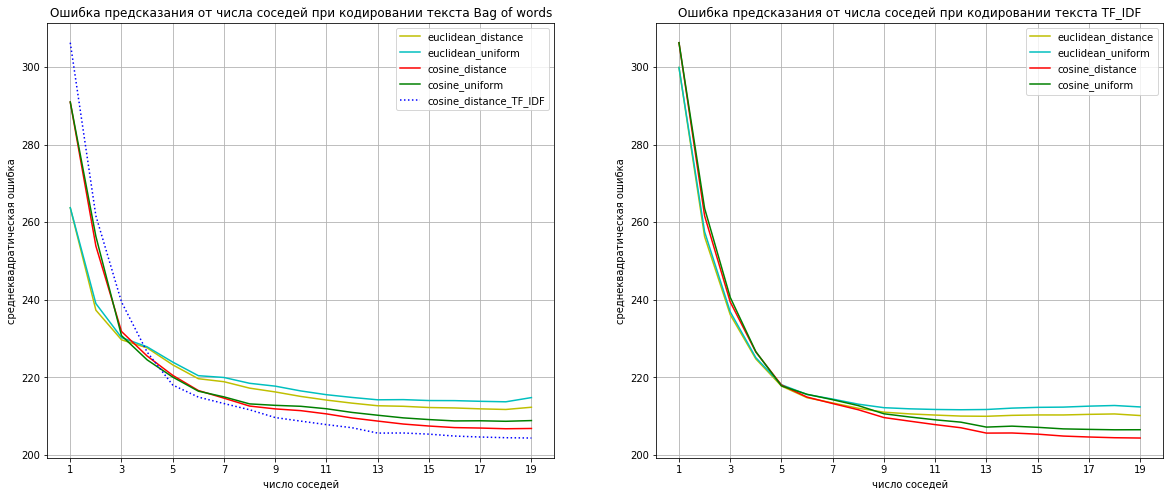

In [438]:
import matplotlib.pyplot as plt

cl = ['euclidean_distance', 'euclidean_uniform', 'cosine_distance', 'cosine_uniform',  'cosine_distance_TF_IDF']
fig, ax = plt.subplots(figsize=(20, 8), ncols = 2)
ax[0].plot(np.arange(1, 20), sc_bw_euc[0],'y', np.arange(1, 20),sc_bw_euc[1], 'c')
ax[0].plot(np.arange(1, 20), sc_bw[0],'r', np.arange(1, 20),sc_bw[1], 'g')
ax[0].plot(np.arange(1, 20), sc_tf[0],'b:')


ax[0].set_xlabel('число соседей')
ax[0].set_ylabel('среднеквадратическая ошибка')
ax[0].set_xticks(np.arange(1, 20, 2))

ax[0].set_title("Ошибка предсказания от числа соседей при кодировании текста Bag of words")
ax[0].legend(cl)
ax[0].grid()

ax[1].plot(np.arange(1, 20), sc_tf_euc[0],'y', np.arange(1, 20),sc_tf_euc[1], 'c')
ax[1].plot(np.arange(1, 20), sc_tf[0],'r', np.arange(1, 20),sc_tf[1], 'g')

ax[1].set_xlabel('число соседей')
ax[1].set_ylabel('среднеквадратическая ошибка')
ax[1].set_xticks(np.arange(1, 20, 2))

ax[1].set_title("Ошибка предсказания от числа соседей при кодировании текста TF_IDF")
ax[1].legend(cl)
ax[1].grid()



Лучшм предсказания по текстовым признакам осуществляется с преобразованием TF-IDF, косинусной метрикой с учеом и весов, при числе соседей 19.

Мешок слов проигрывает в точности, потому что содержит информацию только о количество слов в каждом признаке, а TF-IDF также добавляет словам вес, связанный с их частотами во всей выборке, что позволяет более корректно считать расстояние.

Косинусная мера дает лучшее качество при работе с текстом, потому учитывает только семантическую составляющую (какие слова в каком отношении входят),но не учитывает длину текста, как евклидова мера.

<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования. Повлияло ли добавление количественного признака на метрику качества?

In [37]:
tmp = data[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'last_review_sec', 
           'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 
            'room_type_p_std', 'host_name_p_std', 'neighbourhood_group_p_std', 'neighbourhood_p_std'
          ]]
tmp = tmp.copy()
tmp.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review_sec,reviews_per_month,calculated_host_listings_count,availability_365,room_type_p_std,host_name_p_std,neighbourhood_group_p_std,neighbourhood_p_std
0,40.64749,-73.97237,1,9,1.539896e+09,0.210000,6,365,173.306079,138.532272,205.530787,65.006769
1,40.75362,-73.98377,1,45,1.558386e+09,0.380000,2,355,290.260465,146.238822,290.645734,272.645578
2,40.80902,-73.94190,3,0,1.561237e+09,1.373221,1,365,173.306079,58.726144,290.645734,153.165342
3,40.68514,-73.95976,1,270,1.562274e+09,4.640000,1,194,290.260465,0.000000,205.530787,557.457392
4,40.79851,-73.94399,10,9,1.542575e+09,0.100000,1,0,290.260465,97.508559,290.645734,371.780449


In [38]:
import sklearn
import scipy

In [40]:
a = np.copy(tmp)
ar = scipy.sparse.csr_matrix.toarray(m)
#m - sparse matrix после кодирования TF-IDF
array = np.hstack((a, ar))

In [59]:
scaler = sklearn.preprocessing.MinMaxScaler()

In [63]:
array = scaler.fit_transform(array)

In [65]:
scipy.sparse.csr_matrix(array)

<48895x9511 sparse matrix of type '<class 'numpy.float64'>'
	with 734804 stored elements in Compressed Sparse Row format>

In [66]:
X_train, X_test, y_train, y_test = train_test_split(array, data[['price']],
                                                    test_size=0.3, random_state=241)

In [67]:
sc = knn_score(X_train, y_train, X_test, y_test, np.arange(10, 25), 'euclidean', 'dist_uni')
np.min(sc, axis = 1), np.argmin(sc, axis = 1)

(array([198.74128218, 200.87861357]), array([2, 2], dtype=int64))

In [68]:
sc

([199.05210702457634,
  199.10962009498127,
  198.741282178921,
  199.0348723031973,
  199.08285638744172,
  199.17365532208433,
  199.28020115518703,
  199.51647420777041,
  199.6917839063538,
  199.84201864489427,
  200.00835077613516,
  200.17006894351272,
  200.34089540286487,
  200.51509756136122,
  200.32968832933213],
 [201.0006393460477,
  201.15614471997674,
  200.87861357081078,
  201.28102898084467,
  201.389404459566,
  201.53665016475833,
  201.67654333565196,
  201.9869055091033,
  202.20569788859913,
  202.3852782314689,
  202.58826370912615,
  202.77565558686192,
  202.96971373177865,
  203.1625330730254,
  202.98227896839182])

Наименьшая среднеквадратичная ошибка предсказания на тесте для метода с весами равна 198.7, без весов - 200.9. Достигается при числе соседей 13. Повышение точности достигается за счет объединения всех признаков, в том числе количественных.
В решении используются все полученные признаки, при этом текстовый признак name преобразован через TF-IDF, категориальные переведены в действительные числа. Также выполнено масштабирование признаков на отрезок [0,1].

## Часть 4: Выводы


При решении задачи с использованием только категориальных признаков лучшая достигнутая точность определяется RMSE=206.5. Расстояние между признаками считается через сглаженный индикатор совпадения. 


При использовании только текстового признака минимальная RMSE=206.5. Текст при этом закодирован методом TF-IDF.


При решении задачи со всеми признаками, включая числовые, ошибка уменьшается до 198.7, то есть использование всех признаков повышет качество работы, хоть и незначительно.



Выполненные эксперименты показывают, что для решения задачи регрессии алгоритмом ближайших соседей важно оптимально настроить гипермапаметры: функцию расстояния между объектами, число ближайших соседей, выбрать преобразованиия для признаков. Сложность заключается в том, что для разных типов признаков, как-то: категориальные, текстовые, числовые, лучшая метрика и число соседей могут не совпадать, что показывает последний эксперимент с подбором количества соседей.